# Mobile Computer Vision

In Mobile Computer Vision, ressource-constrained devices are used to run models. In general, there are three ways to make a model ready for mobile deployment:
- make it smaller (less weights, less layers)
- prune it 
- quantize the weights

Consider [https://xilinx.github.io/Vitis-AI/3.5/html/docs/workflow.html](https://xilinx.github.io/Vitis-AI/3.5/html/docs/workflow.html) for an introduction.

For now, we just want to find a small model for the plane detection dataset.


In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from matplotlib import pyplot as plt

# Data
The data is available from  [https://api.bgd.ed.tum.de/datasets/gaofen-plane-noplane/](https://api.bgd.ed.tum.de/datasets/gaofen-plane-noplane/). Download it to the folder, where this notebook is placed and unpack it such that a subfolders gaofen is there which looks like this:

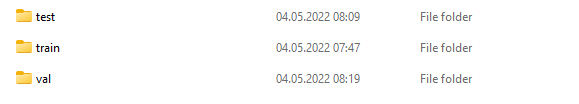

Expect errors in the training code, when something is wrong with your paths. Note that the paths are relative to where you start Jupyter notebook, not where your notebook is located. That is, be sure to run jupyter notebook in the right folder. If you are not getting it to work, you can use absolute paths as well. 

# Base Model: MobileNet
We use the MobileNet model which implements a smart way to reduce multiplications using Depth-Wise convolution. It is a model that provides simplifications such that it can be used on a mobile phone easily.

In [2]:
def conv_layer(x, filters, stride=1):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(stride,stride), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    return x


def depthwise_conv_layer(x, filters, stride=1, depth_multiplier=1):
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(stride,stride), padding='same', depth_multiplier=depth_multiplier, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)


    x = tf.keras.layers.Conv2D(filters, kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    return x


def mobilenet(input_tensor, alpha=1.0, depth_multiplier=1, include_top = False, classes=1000, classifier_activation='softmax'):
    """_summary_
    Args:
        alpha (float, optional): controls the width of the network.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        depth_multiplier (int, optional): The number of depthwise convolution output channels
            for each input channel. Defaults to 1.
    """
    x = tf.keras.layers.ZeroPadding2D()(input_tensor)
    x = conv_layer(x, int(32 * alpha), 2)
    x = depthwise_conv_layer(x, int(64 * alpha), depth_multiplier=depth_multiplier)
    x = tf.keras.layers.ZeroPadding2D()(x)
    x = depthwise_conv_layer(x, int(128 * alpha), 2, depth_multiplier=depth_multiplier)
    x = depthwise_conv_layer(x, int(128 * alpha), depth_multiplier=depth_multiplier)
    x = tf.keras.layers.ZeroPadding2D()(x)
    x = depthwise_conv_layer(x, int(256 * alpha), 2, depth_multiplier=depth_multiplier)
    x = depthwise_conv_layer(x, int(256 * alpha), depth_multiplier=depth_multiplier)
    x = tf.keras.layers.ZeroPadding2D()(x)
    x = depthwise_conv_layer(x, int(512 * alpha), 2, depth_multiplier=depth_multiplier)

    x = depthwise_conv_layer(x, int(512 * alpha), depth_multiplier=depth_multiplier)
    x = depthwise_conv_layer(x, int(512 * alpha), depth_multiplier=depth_multiplier)
    x = depthwise_conv_layer(x, int(512 * alpha), depth_multiplier=depth_multiplier)
    x = depthwise_conv_layer(x, int(512 * alpha), depth_multiplier=depth_multiplier)
    x = depthwise_conv_layer(x, int(512 * alpha), depth_multiplier=depth_multiplier)

    x = tf.keras.layers.ZeroPadding2D()(x)
    x = depthwise_conv_layer(x, int(1024 * alpha), 2, depth_multiplier=depth_multiplier)
    x = depthwise_conv_layer(x, int(1024 * alpha), 2, depth_multiplier=depth_multiplier)

#   This are the layer which has been used to train imagenet
#   x = tf.keras.layers.GlobalAveragePooling2D()(x)
#   x = tf.keras.layers.Flatten()(x)
#   x = tf.keras.layers.Dense(units= classes, activation=classifier_activation)(x)
    
    return x

# Building a model out of it
This just prvovides a sequence of layers (a quite deep neural network, maybe you need to train on a GPU)

In [4]:
cfg = {
  "dataset": "gaofen",
  "img_input_shape": [
    224,
    224,
    3
  ],
  "number_of_classes": 2,
  "lr1": 1e-4,
  "epochs": 15
}


In [14]:
new_inputs = tf.keras.layers.Input(shape=cfg["img_input_shape"])
x = mobilenet(new_inputs)

#conv = tf.keras.Model(new_inputs, x)
#conv.load_weights("imagenet_mobilenet.h5") # here, we could inject pre-trained weights, I will provide you some on the dataset page

x = tf.keras.layers.Flatten()(x)
new_outputs = tf.keras.layers.Dense(cfg["number_of_classes"], activation='softmax')(x)

model = tf.keras.Model(new_inputs, new_outputs)

loss_fn = keras.losses.CategoricalCrossentropy() #from_logits=True
optimizer = keras.optimizers.Adam(learning_rate = cfg["lr1"])
    
use_metrics=['accuracy']
# print(model.summary())
model.compile(optimizer=optimizer, loss = loss_fn, metrics=use_metrics)
# data

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1 / 255.0)
train_generator = train_datagen.flow_from_directory(
    directory= "./gaofen/train/",
    target_size=(cfg["img_input_shape"][0],cfg["img_input_shape"][1]),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
    )
valid_generator = train_datagen.flow_from_directory(
    directory= "./gaofen/val/",
    target_size=(cfg["img_input_shape"][0],cfg["img_input_shape"][1]),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
    )
test_generator = train_datagen.flow_from_directory(
    directory= "./gaofen/test/",
    target_size=(cfg["img_input_shape"][0],cfg["img_input_shape"][1]),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
    )

# Sometimes, your weights will go NaN (e.g., too large LR)
# and it is not automatic that the job ends then. But we want to.
    
callbacks = [ keras.callbacks.TerminateOnNaN() ]

model.fit(train_generator,
    validation_data=valid_generator,
    epochs=cfg["epochs"],
    callbacks = callbacks,
    verbose=1
    )
model.save("mobilenet-gaofen.h5")


Found 5722 images belonging to 2 classes.
Found 2729 images belonging to 2 classes.
Found 2492 images belonging to 2 classes.


C:\Users\marti\AppData\Local\Temp\ipykernel_17008\4282542236.py:58: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/15
178/178 [==============================] - 459s 2s/step - loss: 0.2217 - accuracy: 0.9125 - val_loss: 1.1922 - val_accuracy: 0.5121
Epoch 2/15
178/178 [==============================] - 378s 2s/step - loss: 0.0983 - accuracy: 0.9652 - val_loss: 2.4825 - val_accuracy: 0.5118
Epoch 3/15
178/178 [==============================] - 323s 2s/step - loss: 0.0710 - accuracy: 0.9763 - val_loss: 2.7862 - val_accuracy: 0.5136
Epoch 4/15
178/178 [==============================] - 318s 2s/step - loss: 0.0525 - accuracy: 0.9830 - val_loss: 1.1160 - val_accuracy: 0.5919
Epoch 5/15
178/178 [==============================] - 301s 2s/step - loss: 0.0474 - accuracy: 0.9837 - val_loss: 0.0739 - val_accuracy: 0.9768
Epoch 6/15
178/178 [==============================] - 280s 2s/step - loss: 0.0393 - accuracy: 0.9854 - val_loss: 0.0950 - val_accuracy: 0.9761
Epoch 7/15
178/178 [==============================] - 280s 2s/step - loss: 0.0301 - accuracy: 0.9902 - val_loss: 0.0938 - val_accuracy: 0.9732

C:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
model.evaluate(test_generator)

78/78 [==============================] - 61s 776ms/step - loss: 0.4432 - accuracy: 0.9362


[0.44316813349723816, 0.9361958503723145]

# Conclusion
The MobileNet architecture provides an architecture deployable to small devices. It is even possible to train it on CPU only in comparably reasonable times for image classification. Detecting planes is possible ;-)
